<a href="https://colab.research.google.com/gist/allanaasilva/19d869377f5957affc84023db5a25e11/tp3_allana_alves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tema:** Classificação
### **Base de dados:** https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [ ]:
#Bibliotecas usadas no projeto
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, roc_auc_score

from warnings import filterwarnings
filterwarnings('ignore')


##**2. Data understanding (Entendimento dos dados)**


In [ ]:
#Carregando a base de dados
file = ('sample_data/healthcare-dataset-stroke-data.csv')  
df = pd.read_csv(file)
df.head()

NameError: ignored

In [ ]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

A variável 'bmi' possui valores nulos, que serão corrigidos na próxima etapa.

In [ ]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Há apenas um indivíduo associado a 'Other' na variável gênero. Este valor será substituído pela moda ('Female') na próxima etapa.

In [ ]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

A maior parte dos indivíduos não sofreram derrame. Esta informação é bastante relevante para a etapa de 'Modeling'.

In [ ]:
# Idade das pessoas que tiveram e que não tiveram derrame
newnames={'1': 'Sim', '0': 'Não'}
fig=px.box(df,x='stroke',y='age',color='stroke',template='ggplot2',labels={'stroke':'Derrame','age':'Idade'},title='<b> Idade de Pessoas que Tiveram ou não Derrame')
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.update_xaxes(visible=False)
fig.show(renderer="colab")

In [ ]:
# Nível de glicose das pessoas que tiveram e que não tiveram derrame
newnames={'1': 'Sim', '0': 'Não'}
fig=px.box(df,x='stroke',y='avg_glucose_level',color='stroke',template='ggplot2',labels={'stroke':'Derrame','avg_glucose_level':'Nível de Glicose'},title='<b> Nível de Glicose no Sangue')
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.update_xaxes(visible=False)
fig.show(renderer="colab")

In [ ]:
# IMC das pessoas que tiveram e que não tiveram derrame
newnames={'1': 'Sim', '0': 'Não'}
fig=px.box(df,x='stroke',y='bmi',color='stroke',template='ggplot2',labels={'stroke':'Derrame','bmi':'IMC'},title='<b> IMC de Pessoas que Tiveram ou não Derrame')
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.update_xaxes(visible=False)
fig.show(renderer="colab")

Não é comum que indivíduos tenham IMC acima de 50, como visto acima. Isto leva  a crer que valores de IMC acima deste patamar sejam outliers. Estes valores serão substituídos pelo valor 50 na próxima etapa.

In [ ]:
# % de Hipertensos dentre os que Tiveram ou não Derrame
df_hypertension = df.groupby('stroke')['hypertension'].mean().sort_values().reset_index()
df_hypertension['stroke'] = df_hypertension['stroke'].map({1: 'Sim', 0: 'Não'})
fig=px.bar(df_hypertension, x='stroke', y='hypertension', color='stroke',labels={'stroke':'Derrame','hypertension':'% Hipertensos'},
           text='stroke',template='seaborn',title='<b> % de Hipertensos que Tiveram ou não Derrame')

fig.show(renderer="colab")

In [ ]:
# % de Pessoas com Doenças no Coração que Tiveram ou não Derrame
df_heart_disease = df.groupby('stroke')['heart_disease'].mean().sort_values().reset_index()
df_heart_disease['stroke'] = df_heart_disease['stroke'].map({1: 'Sim', 0: 'Não'})
fig=px.bar(df_heart_disease, x='stroke', y='heart_disease', color='stroke',labels={'stroke':'Derrame','heart_disease':'% Doenças do Coração'},
           text='stroke',template='seaborn',title='<b> % de Pessoas com Doenças no Coração que Tiveram ou não Derrame')

fig.show(renderer="colab")

##**3. Data preparation (Preparação dos dados)**

Como visto na etapa anterior, a variável que indica índice de massa corporal possui alguns valores nulos. Esses valores serão substituídos pela mediana desta variável. Além disso, a variável 'id' será desconsiderada, por se tratar apenas de um identificador. Na variável gênero, também conforme etapa anterior, há apenas um valor associado a 'Others'. Neste caso, este valor será substituído pela moda da variável.

Estas alterações podem ser vistas abaixo:

In [ ]:
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
df = df.drop(columns ='id')
df['gender'] = df['gender'].replace('Other', list(df.gender.mode().values)[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


Valores de IMC acima de 50 são bastante incomuns. Ainda assim, há observações que colores bem acima deste patamar. Isso será corrigido, substituindo estes valores discrepantes por 50.

In [ ]:
df["bmi"] = pd.to_numeric(df["bmi"])
median = df["bmi"].median()
df["bmi"] = df["bmi"].apply(lambda x: median if x>50 else x)

As últimas alterações se referem a adequação das variáveis categóricas e ao dimensionamento das variáveis para o intervalo de [0, 1].

In [ ]:
colunas_categoricas = ['gender','ever_married',	'work_type', 'Residence_type', 'smoking_status']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore'),
    colunas_categoricas),
    remainder='passthrough')

df_one_hot_enc = one_hot_enc.fit_transform(df)
df_one_hot_enc = pd.DataFrame(df_one_hot_enc, columns=one_hot_enc.get_feature_names_out())

scaler = MinMaxScaler()
scaler.fit(df_one_hot_enc)
scale = scaler.transform(df_one_hot_enc)
df_scale = pd.DataFrame(scale, columns=df_one_hot_enc.columns)
df_scale.head()

,onehotencoder__gender_Female,onehotencoder__gender_Male,onehotencoder__ever_married_No,onehotencoder__ever_married_Yes,onehotencoder__work_type_Govt_job,onehotencoder__work_type_Never_worked,onehotencoder__work_type_Private,onehotencoder__work_type_Self-employed,onehotencoder__work_type_children,onehotencoder__Residence_type_Rural,...,onehotencoder__smoking_status_Unknown,onehotencoder__smoking_status_formerly smoked,onehotencoder__smoking_status_never smoked,onehotencoder__smoking_status_smokes,remainder__age,remainder__hypertension,remainder__heart_disease,remainder__avg_glucose_level,remainder__bmi,remainder__stroke
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.816895,0.0,1.0,0.801265,0.664141,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.743652,0.0,0.0,0.679023,0.449495,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.975586,0.0,1.0,0.234512,0.560606,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.597168,0.0,0.0,0.536008,0.608586,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.963379,1.0,0.0,0.549349,0.345960,1.0


##**4. Modeling (Modelagem)**

Será usada a regressão logística para estimar a probabilidade de que alguém tenha derrame. O modelo será ajustado usando o conjunto de treinamento, que consistirá em 65% do conjunto de dados. Para que seja estimada a probabilidade de corte (probabilidade acima da qual se considera que alguém corre o risco de sofrer derrame), serão usados 15% dos dados (conjunto de validação). Os outros 20% serão usados como teste, para avaliação final do modelo.

In [ ]:
x=df_scale.drop(['remainder__stroke'], axis=1)
y=df_scale['remainder__stroke']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state= 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state= 42)

model_RL = LogisticRegression(random_state=42)
model_RL.fit(x_train, y_train)

pred_proba_df = pd.DataFrame(model_RL.predict_proba(x_val))
threshold_list = [0.05,0.1,0.2,0.3,0.4,0.5]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.iloc[:,1].apply(lambda x: 1 if x>i else 0)
    trend_f1 = f1_score(y_val, Y_test_pred)
    trend_rec = recall_score(y_val, Y_test_pred)
    print('F1 score {}'.format(trend_f1))
    print('Recall {}'.format(trend_rec))


******** For i = 0.05 ******
F1 score 0.2037037037037037
Recall 0.8148148148148148

******** For i = 0.1 ******
F1 score 0.23255813953488372
Recall 0.5555555555555556

******** For i = 0.2 ******
F1 score 0.24
Recall 0.2222222222222222

******** For i = 0.3 ******
F1 score 0.23529411764705882
Recall 0.14814814814814814

******** For i = 0.4 ******
F1 score 0.07142857142857142
Recall 0.037037037037037035

******** For i = 0.5 ******
F1 score 0.0
Recall 0.0


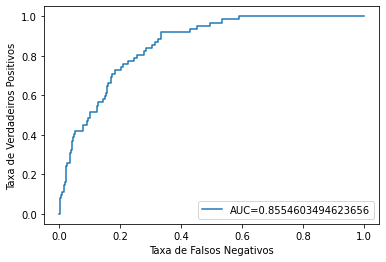

In [ ]:
# Curva ROC
y_pred_proba = model_RL.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Negativos')
plt.legend(loc=4)
plt.show()

As métricas consideradas foram F1 score e recall, pelo fato de ser mais relevante prever corretamente os casos positivos. A probabilidade de corte usada será 5%. 

In [ ]:
svclassifier = SVC(kernel='linear', gamma="auto", class_weight={1: 10}) 
svclassifier.fit(x_train, y_train)

SVC(class_weight={1: 10}, gamma='auto', kernel='linear')

##**5. Evaluation (Validação)**


Primeiramente, para comparação, foi analisada a matriz de confusão gerada pelo modelo com corte para probabilidades acima de 50% (default). Este modelo não consegue prever nenhum derrame, ou seja, não há nenhum verdadeiro positivo. 

Acurácia: 0.9393346379647749
F1 Score: 0.0
Recall: 0.0
Precisão: 0.0



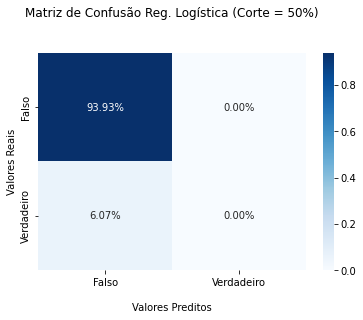

In [ ]:
yhat = model_RL.predict(x_test)
yhat = pd.DataFrame(yhat, index=x_test.index, columns=['Prediction'])

diff_true = np.sign(y_test.diff().dropna())
diffhat = np.sign(yhat.diff().dropna())

trend_acc = accuracy_score(y_test, yhat['Prediction'])
trend_f1 = f1_score(y_test, yhat['Prediction'])
trend_rec = recall_score(y_test, yhat['Prediction'])
trend_pre = precision_score(y_test, yhat['Prediction'])

print(f'Acurácia: {trend_acc}\n'+
f'F1 Score: {trend_f1}\n'+
f'Recall: {trend_rec}\n'+
f'Precisão: {trend_pre}\n')

# Plots

cf_matrix = confusion_matrix(y_test, yhat)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de Confusão Reg. Logística (Corte = 50%)\n\n')
ax.set_xlabel('\nValores Preditos')
ax.set_ylabel('Valores Reais')

ax.xaxis.set_ticklabels(['Falso','Verdadeiro'])
ax.yaxis.set_ticklabels(['Falso','Verdadeiro'])

plt.show()

Já a matriz de confusão gerada pelo modelo com corte para probabilidade acima de 5%, embora gere uma quantidade de pouco mais 25% de falsos positivos, reduz drasticamente a quantidade de falsos negativos (pouco menos de 1.3%). Este modelo acaba sendo mais interessante, pelo fato de conseguir prever alguns dos possíveis derrames. É muito mais preocupante que se tenham falsos negativos do que falsos positivos no problema em questão. 

O fato de o conjunto de dados não ter tantas amostras prejudicou o treinamento do modelo.

Acurácia: 0.7377690802348337
F1 Score: 0.2717391304347826
Recall: 0.8064516129032258
Precisão: 0.16339869281045752



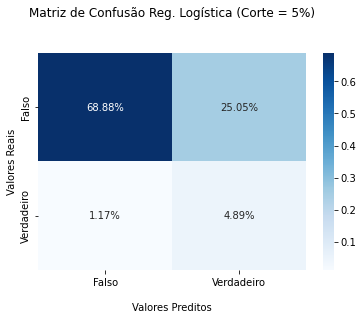

In [ ]:
yhat = pd.DataFrame(model_RL.predict_proba(x_test))
yhat['Prediction'] = yhat.iloc[:,1].apply(lambda x: 1 if x>0.05 else 0)

trend_acc = accuracy_score(y_test, yhat['Prediction'])
trend_f1 = f1_score(y_test, yhat['Prediction'])
trend_rec = recall_score(y_test, yhat['Prediction'])
trend_pre = precision_score(y_test, yhat['Prediction'])

print(f'Acurácia: {trend_acc}\n'+
f'F1 Score: {trend_f1}\n'+
f'Recall: {trend_rec}\n'+
f'Precisão: {trend_pre}\n')

# %% Plots

cf_matrix = confusion_matrix(y_test, yhat['Prediction'])

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de Confusão Reg. Logística (Corte = 5%)\n\n')
ax.set_xlabel('\nValores Preditos')
ax.set_ylabel('Valores Reais')

ax.xaxis.set_ticklabels(['Falso','Verdadeiro'])
ax.yaxis.set_ticklabels(['Falso','Verdadeiro'])

plt.show()

Acurácia: 0.8297455968688845
F1 Score: 0.32031249999999994
Recall: 0.6612903225806451
Precisão: 0.211340206185567



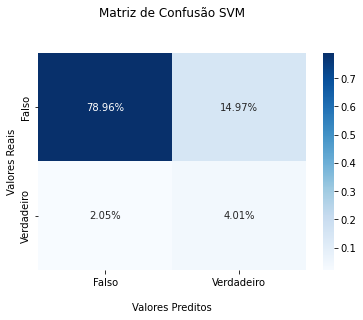

In [ ]:
yhat = pd.DataFrame(svclassifier.predict(x_test))

trend_acc = accuracy_score(y_test, yhat.iloc[:, 0])
trend_f1 = f1_score(y_test, yhat.iloc[:, 0])
trend_rec = recall_score(y_test, yhat.iloc[:, 0])
trend_pre = precision_score(y_test, yhat.iloc[:, 0])

print(f'Acurácia: {trend_acc}\n'+
f'F1 Score: {trend_f1}\n'+
f'Recall: {trend_rec}\n'+
f'Precisão: {trend_pre}\n')

# %% Plots

cf_matrix = confusion_matrix(y_test, yhat.iloc[:, 0])

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de Confusão SVM\n\n')
ax.set_xlabel('\nValores Preditos')
ax.set_ylabel('Valores Reais')

ax.xaxis.set_ticklabels(['Falso','Verdadeiro'])
ax.yaxis.set_ticklabels(['Falso','Verdadeiro'])

plt.show()

Mais comentários a respeito dos resultados obtidos estão no relatório final.